In [1]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
from numpy import log as ln
G = 6.674E-11  # m^3 kg^-1 s^-2
Msun = 1.989E30  # kg
import numpy as np
import numpy.ma as ma
from scipy.special import kn
from scipy.special import iv
gamma = 3.3308
kappa = gamma * ln(10)
import emcee
import corner

In [2]:
r = np.linspace(1e-10,30,1000)

# de Vaucouleur's bule

<ipython-input-3-b1d925e4b572>:16: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vol_den, vol_den_err = inte.quad(density_integrand, r, np.inf, args=(r, SigBE, Rb))
<ipython-input-3-b1d925e4b572>:16: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vol_den, vol_den_err = inte.quad(density_integrand, r, np.inf, args=(r, SigBE, Rb))
<ipython-input-3-b1d925e4b572>:27: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  bulge_mass[i],err[i] = inte.quad(mass_integrand, 0, r[i], args=(SigBE, Rb))
<ipython-input-3-b1d925e4b572>:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the li

Text(0.5, 1.0, 'MW Bulge [de Vaucouleur]')

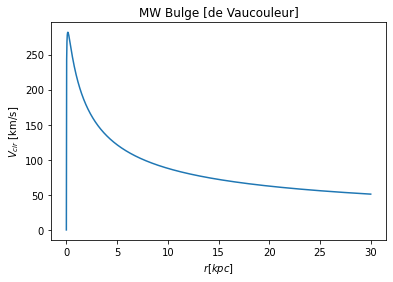

In [3]:
def sigma_b(x, SigBE, Rb):
    return SigBE * np.exp(-1 * kappa * ((x / Rb) ** 0.25 - 1))


# derivative of sigma with respect to r
def dsdx(x, SigBE, Rb):
    return sigma_b(x, SigBE, Rb) * (-0.25 * kappa) * (Rb ** -0.25) * (x ** -0.75)


# integrand for getting denisty
def density_integrand(x, r, SigBE, Rb):
    return -(1 / np.pi) * dsdx(x, SigBE, Rb) / np.sqrt(x ** 2 - r ** 2)


def mass_integrand(r, SigBE, Rb):
    vol_den, vol_den_err = inte.quad(density_integrand, r, np.inf, args=(r, SigBE, Rb))
    return 4 * np.pi * vol_den * r ** 2

def vcir_b(r,SigBE, Rb):
    if isinstance(r, float):
        bulge_mass, m_err = inte.quad(mass_integrand, 0, r, args=(SigBE, Rb))
    else:
        bulge_mass = np.zeros(len(r))
        err = np.zeros(len(r))

        for i in range(len(r)):
            bulge_mass[i],err[i] = inte.quad(mass_integrand, 0, r[i], args=(SigBE, Rb))
    vel = np.sqrt(G*(bulge_mass*Msun)/(r*3.08E16))
    vel /= 1000
    
    return vel

dv_vcir = vcir_b(r*1000,3.2E3, 0.5E3)

plt.plot(r, dv_vcir)
plt.xlabel('$r [kpc]$')
plt.ylabel('$V_{cir}$ [km/s]')
plt.title('MW Bulge [de Vaucouleur]')

# Solid sphere

Text(0.5, 1.0, 'MW Bulge [Solid sphere]')

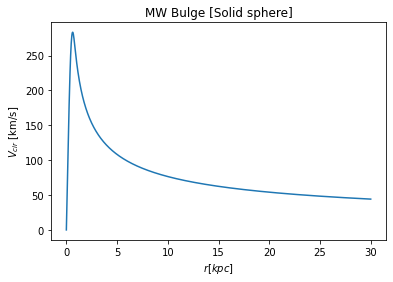

In [8]:
def bulge_vel(r,rho_0,Rb):
    if isinstance(r,float):
        mass_b = 4 * np.pi * rho_0 * ((-1/3*Rb**3*np.exp(-(r/Rb)**3)+(1/3)*(Rb**3)))
    else:
        mass_b = np.zeros(len(r))
        for i in range(len(r)):
            mass_b[i] = 4 * np.pi * rho_0 * ((-(1/3)*(Rb**3)*np.exp(-(r[i]/Rb)**3)+(1/3)*(Rb**3)))
    vel = np.sqrt((G * mass_b * Msun) / (r * 3.086e16))
    return vel/1000

plt.plot(r,bulge_vel(r*1000,26,0.5*1000))
plt.xlabel('$r [kpc]$')
plt.ylabel('$V_{cir}$ [km/s]')
plt.title('MW Bulge [Solid sphere]')

# Compare

Text(0.5, 1.0, 'de Vauc vs Feng')

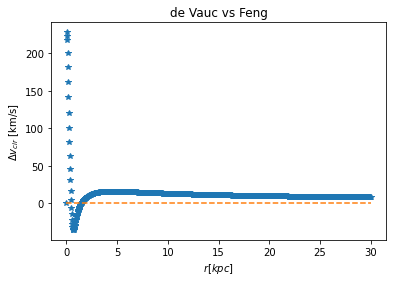

In [5]:
delta_v = np.zeros(len(r))
zero_line = np.zeros(len(r))
for i in range(len(r)):
    delta_v[i] = dv_vcir[i] - bulge_vel(r[i]*1000,25,0.5*1000)
    
plt.plot(r, delta_v,'*')
plt.plot(r, zero_line, '--')
plt.xlabel('$r [kpc]$')
plt.ylabel('$\Delta v_{cir}$ [km/s]')
plt.title('de Vauc vs Feng')

Text(0.5, 1.0, 'MW Bulge [modified Di Paolo]')

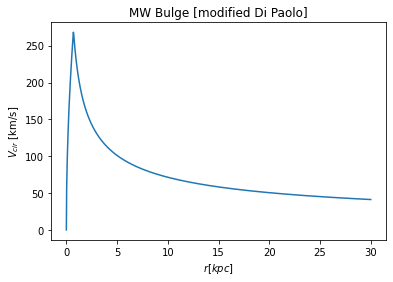

In [6]:
def bulge_vel_mod(r, A, Vin, Rd):
    if isinstance(r, float):
        if r < 0.2 * Rd:
            v = np.sqrt(A*Vin**2*r/(0.2*Rd))
        else:
            v = np.sqrt(A * Vin **2 * (r/(0.2*Rd)) ** -1)
    else:
        v = np.zeros(len(r))
        for i in range(len(r)):
            if r[i] < 0.2 * Rd:
                v[i] = np.sqrt(A*Vin**2*r[i]/(0.2*Rd))
            else:
                v[i] = np.sqrt(A * Vin **2 * (r[i]/(0.2*Rd)) ** -1)
    return v

plt.plot(r,bulge_vel_mod(r*1000,1,270,3500))
plt.xlabel('$r [kpc]$')
plt.ylabel('$V_{cir}$ [km/s]')
plt.title('MW Bulge [modified Di Paolo]')

Text(0.5, 1.0, 'Feng vs Modified Di Paolo')

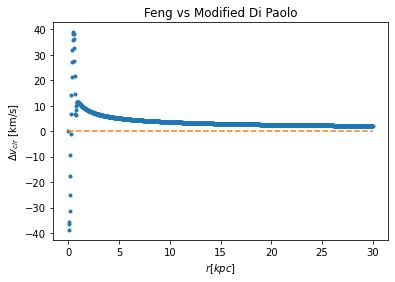

In [10]:
delta_v = np.zeros(len(r))
zero_line = np.zeros(len(r))
for i in range(len(r)):
    delta_v[i] = bulge_vel(r[i]*1000,25,0.5*1000) - bulge_vel_mod(r[i]*1000,1,270,3500)
    
plt.plot(r, delta_v,'.')
plt.plot(r, zero_line, '--')
plt.xlabel('$r [kpc]$')
plt.ylabel('$\Delta v_{cir}$ [km/s]')
plt.title('Feng vs Modified Di Paolo')